In [ ]:
#!pip install gymnasium
#!pip install gymnasium[atari]
#!pip install gymnasium[accept-rom-license]
#!pip install --upgrade gym ale-py

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import gymnasium
import torch
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
env = gymnasium.make("ALE/Tetris-ram-v5")

In [ ]:
env.observation_space.shape[0]

128

In [4]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
            probs = torch.ones(n_action) * epsilon / n_action
            q_values = estimator.predict(state)
            best_action = torch.argmax(q_values).item()
            probs[best_action] += 1.0 - epsilon
            action = torch.multinomial(probs, 1).item()
            return action
    return policy_function

In [8]:
class LR_Estimate():
    def __init__(self, n_feat, n_state, n_action, lr=0.05):#n_state - размерность состояний теперь
        self.w, self.b = self.get_gaussian_wb(n_feat,n_state)
        self.n_feat = n_feat
        self.models = []
        self.optimizers = []
        self.criterion = torch.nn.MSELoss()
        for _ in range(n_action):
            model = torch.nn.Linear(n_feat,1)
            self.models.append(model)
            optimizer = torch.optim.SGD(model.parameters(), lr)
            self.optimizers.append(optimizer)

    def get_gaussian_wb(self, n_feat, n_state, sigma=.2):
        torch.manual_seed(0)
        w = torch.randn((n_state,n_feat))/sigma
        b = torch.rand((n_feat))* 2.0 * np.pi
        return w, b

    def get_feature(self, s):
        features = (2.0 / self.n_feat) ** 0.5 * torch.cos(torch.matmul(torch.Tensor(s).float(), self.w) + self.b)

        return features

    def update(self, s, a, y):
        features = Variable(self.get_feature(s))
        y_pred = self.models[a](features)

        loss = self.criterion(y_pred, Variable(torch.Tensor([y])))

        self.optimizers[a].zero_grad()
        loss.backward()
        self.optimizers[a].step()

    def predict(self,s):
        features = self.get_feature(s)
        # print(features)
        with torch.no_grad():
            m = [model(features) for model in self.models]
            b = torch.Tensor(len(m), len(m[0]))

            torch.cat(m, out=b)
            return b

In [ ]:
estimator = LR_Estimate(10, env.observation_space.shape[0], env.action_space.n)
policy = gen_epsilon_greedy_policy(estimator, 0.1, env.action_space.n)

In [ ]:
rewards = np.zeros(30)
for traj_num in range(30):
    state = env.reset()[0]
    is_done = False
    while not is_done:
      action = policy(state)
      new_state, reward, is_done, __,  info = env.step(action)
      state = new_state
      rewards[traj_num] += reward
      rewards[traj_num] += 0.01

<ipython-input-22-e22f447b083a>:42: UserWarning: An output with one or more elements was resized since it had shape [5, 1], which does not match the required output shape [5]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  torch.cat(m, out=b)


In [ ]:
rewards

array([5.05, 3.97, 4.88, 3.89, 4.61, 4.01, 3.85, 3.79, 3.73, 4.13, 4.13,
       4.33, 5.05, 3.85, 3.85, 3.53, 3.89, 6.17, 3.89, 4.73, 4.33, 4.41,
       4.01, 3.89, 4.13, 3.87, 3.93, 5.77, 4.01, 4.49])

In [ ]:
mean_reward = sum(rewards) / len(rewards)

In [ ]:
mean_reward

4.272333333333287

In [ ]:
interval = stats.norm.interval(0.95, loc=mean_reward, scale=stats.tstd(rewards, axis=0))
print(interval)

(3.0843223594152898, 5.460344307251284)


In [ ]:
n_episode = 500
total_reward_episode = [0] * n_episode

In [10]:
def q_learning(env, estimator, n_episode, epsilon, n_action, gamma=1.0, epsilon_decay=0.99):
    for episode in range(n_episode):
        policy = gen_epsilon_greedy_policy(estimator, epsilon * epsilon_decay ** episode, n_action)
        state = env.reset()[0]
        is_done = False
        while not is_done:
            action = policy(state)
            new_state, reward, is_done, __,  info = env.step(action)
            q_values_next = estimator.predict(new_state)
            if reward == 0:
              reward = 0.01
            else:
              reward = 100
            td_target = reward + gamma * torch.max(q_values_next)
            estimator.update(state, action, td_target)
            total_reward_episode[episode] += reward
        state = new_state

In [ ]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 100
lr = 0.03
estimator = LR_Estimate(n_feature, n_state, n_action, lr)

q_learning(env, estimator, n_episode, 0.1, n_action)

<ipython-input-22-e22f447b083a>:42: UserWarning: An output with one or more elements was resized since it had shape [5, 1], which does not match the required output shape [5]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ../aten/src/ATen/native/Resize.cpp:28.)
  torch.cat(m, out=b)


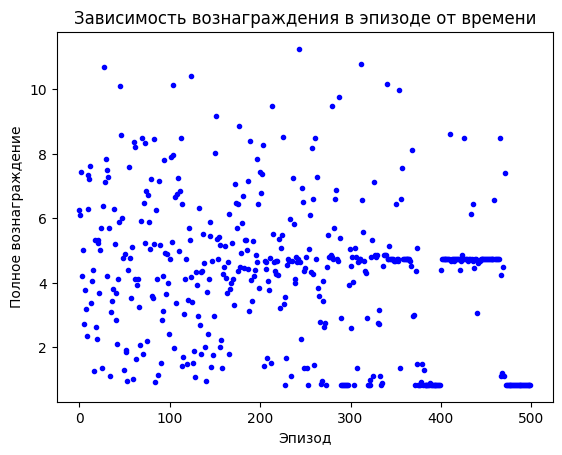

In [ ]:
plt.plot(total_reward_episode, 'b.')
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()

Second experiment

In [9]:
n_episode = 2000
total_reward_episode = [0] * n_episode

In [11]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 100
lr = 0.03
estimator = LR_Estimate(n_feature, n_state, n_action, lr)

q_learning(env, estimator, n_episode, 0.1, n_action)

C:\Users\Aron\AppData\Local\Temp\ipykernel_21592\1578489185.py:42: UserWarning: An output with one or more elements was resized since it had shape [5, 1], which does not match the required output shape [5]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at ..\aten\src\ATen\native\Resize.cpp:35.)
  torch.cat(m, out=b)


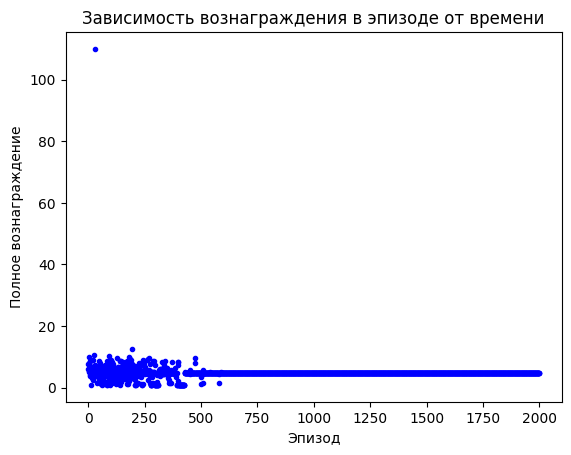

In [12]:
plt.plot(total_reward_episode, 'b.')
plt.title('Зависимость вознаграждения в эпизоде от времени')
plt.xlabel('Эпизод')
plt.ylabel('Полное вознаграждение')
plt.show()

In [14]:
mean_reward2 = sum(total_reward_episode) / len(total_reward_episode)
interval2 = stats.norm.interval(0.95, loc=mean_reward2, scale=stats.tstd(total_reward_episode, axis=0))

In [15]:
print(mean_reward2)
print(interval2)

4.814170000000177
(-0.27846430731094607, 9.9068043073113)
